In [1]:
!pip install tf-agents


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import random

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import tempfile
import zipfile
import tensorflow_probability as tfp

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.networks import network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.distributions.utils import SquashToSpecNormal
from tf_agents.networks import normal_projection_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import policy_saver
from tf_agents.specs import tensor_spec
from tf_agents.agents.sac import tanh_normal_projection_network

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent


tf.compat.v1.enable_v2_behavior()

import os
import shutil

try:
  from google.colab import files
except ImportError:
  files = None


from google.colab import drive 
drive.mount('/content/gdrive') 

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())


%xmode Verbose

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Exception reporting mode: Verbose


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

KeyboardInterrupt: ignored

In [4]:
# use "num_iterations = 1e6" for better results,
# 1e5 is just so this doesn't take too long. 
num_iterations =  100000# @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (100, 100, 100)
critic_joint_fc_layer_params = (100, 100, 100)

log_interval =  1000# @param {type:"integer"}

num_eval_episodes =  10# @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

eval_returns_amt = 100 # @param {type:"integer"}


In [25]:
_RHO = np.radians(270)
fname = "svo-270-1"

def angular_reward(rho):
  return (lambda x, y: np.cos(rho) * x + np.sin(rho) * y)
def reward_fun(self, other):
  f = angular_reward(_RHO)
  return f(self, other)


def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

reward_fun(70, 70)


-70.00000000000001

In [6]:

def construct_agent(observation_spec, action_spec, time_step_spec):
  agent_array_action_spec = action_spec
  agent_array_observation_spec = observation_spec

  agent_action_spec = tensor_spec.from_spec(agent_array_action_spec)
  agent_observation_spec = tensor_spec.from_spec(agent_array_observation_spec)


  critic_net = critic_network.CriticNetwork(
    (agent_observation_spec, agent_action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)


  actor_net = actor_distribution_network.ActorDistributionNetwork(
    agent_observation_spec,
    agent_action_spec,
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=tanh_normal_projection_network
        .TanhNormalProjectionNetwork
    )

  value_net = value_network.ValueNetwork(observation_spec)

  global_step = tf.compat.v1.train.get_or_create_global_step()

  tf_agent = sac_agent.SacAgent(
      time_step_spec,
      agent_action_spec,
      actor_network=actor_net,
      critic_network=critic_net,
      actor_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=actor_learning_rate),
      critic_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=critic_learning_rate),
      alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
          learning_rate=alpha_learning_rate),
      target_update_tau=target_update_tau,
      target_update_period=target_update_period,
      td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
      gamma=gamma,
      reward_scale_factor=reward_scale_factor,
      gradient_clipping=gradient_clipping,
      train_step_counter=global_step)
  tf_agent.initialize()
  return tf_agent





In [7]:
import sys
sys.path.append('/content/gdrive/My Drive/colab+git')
import pgg

pgg.reward_fun = reward_fun

def create_env():
  return tf_py_environment.TFPyEnvironment(pgg.PublicGoodsEnv())

def validate_random(environment, episodes):
  time_step_spec = environment.time_step_spec()
  action_spec = environment.action_spec()

  episode_count = 0
  time_step = environment.reset()

  while episode_count < episodes:
    if not array_spec.check_arrays_nest(time_step, time_step_spec):
      raise ValueError(
          'Given `time_step`: %r does not match expected `time_step_spec`: %r' %
          (time_step, time_step_spec))
    obs = time_step.observation
    action0 = [random.uniform(0, 1)]
    action1 = [random.uniform(0, 1)]

    new_action = [action0[0], action1[0]]
    time_step = environment.step(new_action)
    print(time_step)

    if time_step.is_last():
        episode_count += 1
        time_step = environment.reset()

#validate_random(pgg.PublicGoodsEnv(), 5)

In [8]:
def make_checkpoint(tf_agent, train_env, checkpoint_dir, replay_buffer):
  train_checkpointer = common.Checkpointer(
      ckpt_dir=checkpoint_dir,
      max_to_keep=1,
      agent=tf_agent,
      policy=tf_agent.policy,
      replay_buffer=replay_buffer,
      global_step=tf_agent.train_step_counter
  )

  return train_checkpointer


In [9]:
def self_play_train(tf_agent, train_env, eval_env, train_checkpointer, replay_buffer):
  def construct_intended_action(policy0, policy1, time_step, print_bool):
    return pgg.construct_intended_action(policy0, policy1, time_step)
  
  def compute_avg_return(environment, policy0, policy1, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        new_action = construct_intended_action(policy0, policy1, time_step, False)
        action_step = ps.PolicyStep(action=new_action)

        time_step = environment.step(action_step.action)
        
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


  """rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(tempdir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)"""
  
  """upload_and_unzip_file_to(os.path.join(tempdir, 'replay_buffer'))
  rb_checkpointer.initialize_or_restore()"""
  
  def collect_step(environment, policy0, policy1):

    time_step = environment.current_time_step()

    new_action = construct_intended_action(policy0, policy1, time_step, False)

    action_step = ps.PolicyStep(action=new_action)


    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

  def collect_data(env, policy0, policy1, steps):
    for _ in range(steps):
      collect_step(env, policy0, policy1)

  collect_data(train_env, tf_agent.collect_policy, tf_agent.collect_policy, steps=100)

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

  iterator = iter(dataset)

  
  
  try:
    %%time
  except:
    pass

  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  tf_agent.train = common.function(tf_agent.train)

  # Reset the train step
  tf_agent.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
  returns = [avg_return]

  for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
      collect_step(train_env, tf_agent.collect_policy, tf_agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.

    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, tf_agent.policy, tf_agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)


  steps = range(0, num_iterations + 1, eval_interval)
  plt.plot(steps, returns)
  plt.ylabel('Average Return')
  plt.xlabel('Step')
  plt.ylim(top=870)

  train_checkpointer.save(tf_agent.train_step_counter.numpy())
  #rb_checkpointer.save(global_step)
  



In [10]:
def save_checkpoint(fname, checkpoint_dir, train_checkpointer, rb_checkpointer):
  checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, fname + '-cp'))
  #rb_checkpoint_zip_filename = create_zip_file(os.path.join(tempdir, 'replay_buffer'), os.path.join(tempdir, fname + '-rb'))
  %pwd
  os.mkdir("gdrive/My Drive/colab+git/"+fname+"-cp")

  shutil.move(checkpoint_zip_filename, "gdrive/My Drive/colab+git/"+fname+"-cp")
  #shutil.move(checkpoint_zip_filename, "gdrive/My Drive/colab+git/"+fname+"-rb")



In [11]:
def unzip_cp(checkpoint_dir, fname, train_checkpointer):
  #try to make checkpoint_dir = fname
  nm = "gdrive/My Drive/colab+git/"+fname+"-cp"
  fl = fname+"-cp.zip"
  with zipfile.ZipFile(os.path.join(nm, fl), 'r') as zip:
    k = zip.extractall(path=checkpoint_dir)
    train_checkpointer.initialize_or_restore()
    zip.close()

In [19]:
import pandas as pd
def play_self(policy, environment):
  ret = []
  done = False
  time_step = environment.reset()

  while not done:
    time_step = environment.current_time_step()
    #print(time_step.observation)
    #print(policy0.distribution(time_step))

    new_action = pgg.construct_intended_action(policy, policy, time_step)
    act = new_action.numpy()[0]
    action_step = ps.PolicyStep(action=new_action)


    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 
    if traj.is_boundary():
      done = True
      return time_step.observation.numpy()

def play_fixed_action(policy, action, environment):
  ret = []
  done = False
  time_step = environment.reset()

  while not done:
    time_step = environment.current_time_step()

    new_action = pgg.construct_fixed_action(policy, action, time_step)
    act = new_action.numpy()[0]
    action_step = ps.PolicyStep(action=new_action)

    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 
    if traj.is_boundary():
      done = True
      return time_step.observation.numpy()

def play_tit_for_tat(policy, environment):
  ret = []
  done = False
  time_step = environment.reset()
  prev_act = 1

  while not done:
    time_step = environment.current_time_step()

    new_action = pgg.construct_fixed_action(policy, prev_act, time_step)
    act = new_action.numpy()[0]
    prev_act = new_action[0].numpy()[0]
    action_step = ps.PolicyStep(action=new_action)

    next_time_step = environment.step(action_step.action)

    traj = trajectory.from_transition(time_step, action_step, next_time_step) #expand 
    if traj.is_boundary():
      done = True
      #print(time_step.reward)
      return time_step.observation.numpy()

def add_graph(graph, obs):
  r, c = np.shape(obs)
  for i in range(r):
    graph[i].append(obs[i][2])

def create_empty_graph():
  ret = []
  for i in range(12):
    ret.append([])
  return ret

def eval_returns(checkpoint_dir, fname, train_checkpointer, eval_env):
  policy = tf_agent.policy


  self_graph = create_empty_graph()
  coop_graph = create_empty_graph()
  defect_graph = create_empty_graph()
  tft_graph = create_empty_graph()
  fixed_game_returns = np.array(range(4), dtype=object)
  s1 = 0
  s2 = 0
  s3 = 0
  s4 = 0


  for _ in range(eval_returns_amt):
    self_g = play_self(policy, eval_env)[0]
    #print(self_g)
    s1 += reward_fun(self_g[11][0], self_g[11][1])
    add_graph(self_graph, self_g)

    nc = (play_fixed_action(policy, 1, eval_env))[0]
    #print(nc)
    s2 += reward_fun(nc[11][0], nc[11][1])
    add_graph(coop_graph, nc)

    nd = (play_fixed_action(policy, 0, eval_env))[0]
    #print(nd)
    s3 += reward_fun(nd[11][0], nd[11][1])
    add_graph(defect_graph, nd)

    nt = (play_tit_for_tat(policy, eval_env))[0]
    #print(nt)
    s4 += reward_fun(nt[11][0], nt[11][1])
    add_graph(tft_graph, nd)


  fixed_game_returns[0] = s1/100
  fixed_game_returns[1] = s2/100
  fixed_game_returns[2] = s3/100
  fixed_game_returns[3] = s4/100

  nm = "gdrive/My Drive/colab+git/fixed_data"
  os.mkdir(os.path.join(nm, fname))
  np.savetxt(os.path.join(nm, fname+"/fixed_game_returns.csv"), fixed_game_returns)
  print('self', 'cooperate', 'defect', 'tit-for-tat', fixed_game_returns)
  fig, axs = plt.subplots(4, sharex=True, sharey=True)


  data0 = np.transpose(np.array(self_graph))
  np.savetxt(os.path.join(nm, fname+"/self_graph.csv"), data0)
  axs[0].set_title('self')
  axs[0].boxplot(data0)

  data1 = np.transpose(np.array(coop_graph))
  np.savetxt(os.path.join(nm, fname+"/coop_graph.csv"), data1)
  axs[1].set_title('coop')
  axs[1].boxplot(data1)

  data2 = np.transpose(np.array(defect_graph))
  np.savetxt(os.path.join(nm, fname+"/defect_graph.csv"), data2)
  axs[2].set_title('defect')
  axs[2].boxplot(data2)

  data3 = np.transpose(np.array(tft_graph))
  np.savetxt(os.path.join(nm, fname+"/self_graph.csv"), data3)
  axs[3].set_title('tft')
  axs[3].boxplot(data3)

  plt.show()






In [13]:
def league(fnames):
  pass


In [14]:
checkpoint_dir = os.path.join(tempdir, fname)
env = create_env()
action_spec = array_spec.BoundedArraySpec(
    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
tf_agent = construct_agent(env.observation_spec(), action_spec, env.time_step_spec())
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_capacity)
tc = make_checkpoint(tf_agent, env, checkpoint_dir, replay_buffer)


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


step = 1000: loss = 294.4498291015625
step = 1000: Average Return = -68.96221923828125
step = 2000: loss = 149.6766815185547
step = 2000: Average Return = -29.631006240844727
step = 3000: loss = 154.16131591796875
step = 3000: Average Return = -14.331991195678711
step = 4000: loss = 124.91138458251953
step = 4000: Average Return = -9.639361381530762
step = 5000: loss = 91.41188049316406
step = 5000: Average Return = -8.67420482635498
step = 6000: loss = 67.21759033203125
step = 6000: Average Return = -6.467054843902588
step = 7000: loss = 49.65966033935547
step = 7000: Average Return = -3.9295687675476074
step = 8000: loss = 40.67811965942383
step = 8000: Average Return = -4.886039733886719
step = 9000: loss = 38.846351623535156
step = 9000: Average Return = -4.947953224182129
step = 10000: loss = 43.325462341308594
step = 10000: Average Return = -5.523388862609863
step = 11000: loss = 32.71586608886719
step = 11000: Average Return = -4.4671831130981445
step = 12000: loss = 30.58387756

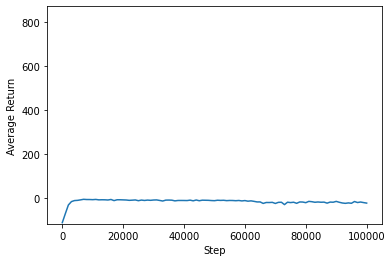

In [ ]:
self_play_train(tf_agent, env, create_env(), tc, replay_buffer)

In [ ]:
save_checkpoint(fname, checkpoint_dir, tc, replay_buffer)


self cooperate defect tit-for-tat [-351.44969116210945 -549.8503228759766 -38.01398258209228
 -459.263346862793]


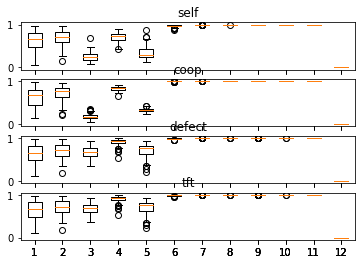

In [20]:
#unzip_cp(checkpoint_dir, fname, tc)

eval_returns(checkpoint_dir, fname, tc, create_env())

In [ ]:
replay_buffer.get_next()


(Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(12, 4), dtype=float32, numpy=
array([[1.0000000e+01, 1.0000000e+01, 7.8967512e-03, 2.0236433e-02],
       [1.0132031e+01, 1.0008635e+01, 3.1565785e-02, 3.4992039e-02],
       [1.0314742e+01, 1.0160948e+01, 2.9243708e-02, 1.1146897e-01],
       [1.1088804e+01, 1.0104021e+01, 1.3635647e-01, 9.3019813e-02],
       [1.1415703e+01, 1.1003076e+01, 3.4014821e-02, 1.5590161e-02],
       [1.1447282e+01, 1.1251418e+01, 4.2745531e-02, 1.5600699e-01],
       [1.2641426e+01, 1.1179584e+01, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)>, action=<tf.Tensor: s